<a href="https://colab.research.google.com/github/FrancescoSarandrea/Audio_GW/blob/main/SpeechClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Audio Classification with Wavelet Scattering Transform and NNs

In [1]:
pip install kymatio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 KB 6.6 MB/s eta 0:00:00


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
from torch.utils.data import DataLoader
import torchvision 
import matplotlib.pyplot as plt
import IPython.display as ipd
from torchsummary import summary
from tqdm.notebook import tqdm

In [2]:
from kymatio.torch import Scattering1D #See: https://www.kymat.io/index.html

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset

See the tutorial https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html and https://arxiv.org/abs/1804.03209 for more details about this dataset.

In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

#Warning: 2.2Giga of dataset
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")


In [5]:
def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


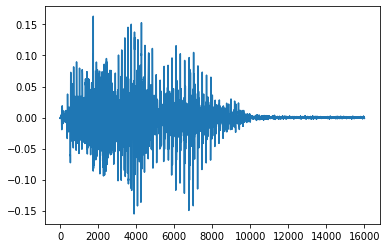

In [6]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[-1]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [7]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

In [8]:
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [9]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [10]:
batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=pin_memory,
)

## NNs utility 

Functions for training and testing.

In [13]:

def evaluate_accuracy(model,transform, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images, y = data
            if transform:
                images=transform(images.to(device))
            else:
                images=images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            total += y.size(0) 
            correct += (predicted == y.to(device)).sum().item()
    accuracy = 100 * correct / total  
    return accuracy

def accuracy_classes(net,transform,dataloader,classes): 
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            if transform:
                images=transform(images.to(device))
            else:
                images=images.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels.to(device), predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
     

In [14]:
def training(net,transform,optimizer,criterion,train_loader,test_loader,num_epochs):
  history={'loss':[],'train_accuracy':[],'val_accuracy':[]}
  for epoch in tqdm(range(num_epochs)):
      running_loss = 0.0
      running_corrects = 0.0
      net.train()
      for i, data in enumerate(train_loader, 0):
          inputs, y = data
          optimizer.zero_grad()
          if transform:
            inputs=transform(inputs.to(device))
          else:
            inputs=inputs.to(device)
          outputs = net(inputs)

          loss = criterion(outputs, y.to(device))
          loss.backward()
          optimizer.step()
 
          _, predicted = torch.max(outputs.data.cpu(), 1)
          running_corrects += torch.sum(predicted == y.data).item()
        
          running_loss += loss.item() * inputs.size(0)
        

      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = 100.0*running_corrects / len(train_loader.dataset)
      val_acc=evaluate_accuracy(net,transform,test_loader)
      history['loss'].append(epoch_loss)
      history['train_accuracy'].append(epoch_acc)
      history['val_accuracy'].append(val_acc)
      print('Epoch {} Loss: {:.4f} Acc: {:.4f}% Val Acc: {:.4f}%'.format(epoch+1, epoch_loss, epoch_acc, val_acc))  
  return history

## Wavelet Newtork

This approach consider the wavelet transformed samples as an image and uses 2 dimensional CNN to classify the preprocessed audio.

In [15]:
class Wavelet:
    def __init__(self, J, T, Q,image_size = 64,sample_rate=16000,device='cuda'):
        '''
        This class does a sequence of transformations.
        1- waveform are reshaped from smaple_rate to T
        2-wavelet scattering transform is then applied to the reshaped signals
        3-the transformed samples are reshaped to a (image_size,image_size)
        4-Finally, batch normalization is applied to the reshaped images
        '''
        self.scattering = Scattering1D(J, T, Q).to(device)
        self.resize = torchvision.transforms.Resize((image_size,image_size)).to(device)
        self.transform= torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=T).to(device)
        self.bn = nn.BatchNorm2d(1).to(device)

    def __call__(self, x):
        x=self.transform(x) #step 1
        #x=x/ torch.max(torch.abs(x))
        x=self.scattering(x.contiguous()) #step 2
        x=self.resize(x) #step 3
        x=self.bn(x) #step 4
        return x

In [16]:
class Flatten(nn.Module):
    def forward(self, input):
        batch_size = input.size(0)
        out = input.view(batch_size,-1)
        return out # (batch_size, *size)

#General convolutional neural network for squared images with size=(img_shape,img_shape)
#The list hidden_sizes fix the numbers of convolutional layers (len(hidden_sizes))
#And the kernel for the ith layer (hidden_sizes[i])
#The activation functions can be choosen between relu, elu and tanh
#Dropout=True ad a dropout to each convolutional layers with porbability p
class WaveletCNN(nn.Module):
    def __init__(self, img_shape, hidden_sizes=[16,32,64],dropout=True,p=0.05,act='relu',input_channel=1,n_classes=35):
        super(WaveletCNN, self).__init__()

        net=[]
        hidden_sizes=[input_channel]+hidden_sizes
        for i in range(len(hidden_sizes)-1):
          net.append(nn.Conv2d(hidden_sizes[i], hidden_sizes[i+1], kernel_size=3, padding=1))
          net.append(nn.BatchNorm2d(hidden_sizes[i+1]))
          if act=='relu':
            net.append(nn.ReLU())
          elif act=='elu':
            net.append(nn.SiLU())
          else:
            net.append(nn.Tanh())
          if dropout:
            net.append(nn.Dropout(p=p))
          net.append(nn.MaxPool2d(kernel_size=2, stride=2))

        net.append(Flatten())
        net.append(nn.Linear(int(hidden_sizes[-1] * (img_shape/(2**(len(hidden_sizes)-1)))**2), n_classes))
        self.net=nn.ModuleList(net)

        
    def forward(self, x):
        for l in self.net:
          x=l(x)
        return x

In [30]:
net=WaveletCNN(64).to(device)

In [31]:
T = 12000
J = 4
Q = 4


In [32]:
wvlt=Wavelet(J,T,Q,64)

In [33]:
summary(net,(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
       BatchNorm2d-2           [-1, 16, 64, 64]              32
              ReLU-3           [-1, 16, 64, 64]               0
           Dropout-4           [-1, 16, 64, 64]               0
         MaxPool2d-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           4,640
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
           Dropout-9           [-1, 32, 32, 32]               0
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          18,496
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
          Dropout-14           [-1, 64,

In [34]:
num_epochs = 15
learning_rate = 0.01

In [35]:
criterion = nn.CrossEntropyLoss() #Another option is to use NegativeLog likelihood in combination with log-sofmatx applied to the NNs output
optimizer = optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4)

In [23]:
history=training(net,wvlt,optimizer,criterion,train_loader,test_loader,num_epochs)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 Loss: 2.5103 Acc: 35.2746% Val Acc: 56.1563%
Epoch 2 Loss: 1.0272 Acc: 71.3035% Val Acc: 75.4112%
Epoch 3 Loss: 0.7471 Acc: 78.9835% Val Acc: 77.3194%
Epoch 4 Loss: 0.6372 Acc: 81.7911% Val Acc: 79.1913%
Epoch 5 Loss: 0.5652 Acc: 83.8054% Val Acc: 80.9905%
Epoch 6 Loss: 0.5140 Acc: 85.0748% Val Acc: 80.3998%
Epoch 7 Loss: 0.4953 Acc: 85.4850% Val Acc: 82.2263%
Epoch 8 Loss: 0.4695 Acc: 86.2416% Val Acc: 80.0454%
Epoch 9 Loss: 0.4578 Acc: 86.5552% Val Acc: 83.4621%
Epoch 10 Loss: 0.4417 Acc: 86.9889% Val Acc: 84.4162%
Epoch 11 Loss: 0.4332 Acc: 87.1952% Val Acc: 82.5716%
Epoch 12 Loss: 0.4266 Acc: 87.2494% Val Acc: 83.5984%
Epoch 13 Loss: 0.4211 Acc: 87.5535% Val Acc: 83.3167%
Epoch 14 Loss: 0.4172 Acc: 87.6395% Val Acc: 84.5706%
Epoch 15 Loss: 0.4114 Acc: 87.7739% Val Acc: 82.9078%


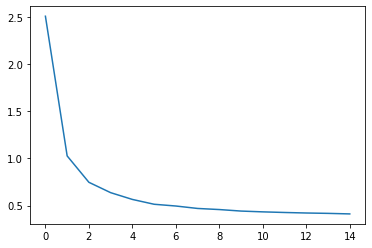

In [24]:
plt.plot(history['loss'])

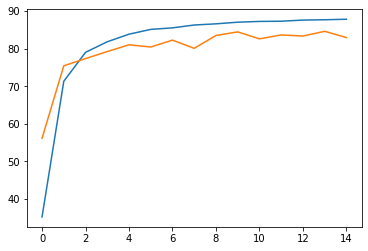

In [25]:
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])

In [26]:
evaluate_accuracy(net,wvlt,test_loader)

82.90776919582008

In [27]:
accuracy_classes(net,wvlt,test_loader,labels)

Accuracy for class: backward is 46.7 %
Accuracy for class: bed   is 68.6 %
Accuracy for class: bird  is 84.9 %
Accuracy for class: cat   is 89.7 %
Accuracy for class: dog   is 77.3 %
Accuracy for class: down  is 86.7 %
Accuracy for class: eight is 85.8 %
Accuracy for class: five  is 82.9 %
Accuracy for class: follow is 72.1 %
Accuracy for class: forward is 71.0 %
Accuracy for class: four  is 72.2 %
Accuracy for class: go    is 70.1 %
Accuracy for class: happy is 69.0 %
Accuracy for class: house is 87.4 %
Accuracy for class: learn is 74.5 %
Accuracy for class: left  is 85.0 %
Accuracy for class: marvin is 94.4 %
Accuracy for class: nine  is 90.0 %
Accuracy for class: no    is 91.1 %
Accuracy for class: off   is 84.8 %
Accuracy for class: on    is 87.9 %
Accuracy for class: one   is 88.2 %
Accuracy for class: right is 82.3 %
Accuracy for class: seven is 89.9 %
Accuracy for class: sheila is 82.1 %
Accuracy for class: six   is 90.1 %
Accuracy for class: stop  is 81.0 %
Accuracy for class: 

## Log-Scattering Transform

The wavelet scattering transform is used as preprocessing for a softmax regression. See: https://www.kymat.io/gallery_1d/plot_classif_torch.html#sphx-glr-gallery-1d-plot-classif-torch-py

In [13]:
class LogScattering:
    def __init__(self,J,T,Q, sample_rate=16000,device='cuda'):
        self.transform= torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=T).to(device)
        self.scattering = Scattering1D(J, T, Q).to(device)
        self.eps=1e-6
    def __call__(self,x):
        x /= torch.max(torch.abs(x))
        x=self.transform(x.squeeze())
        x=self.scattering(x.contiguous())
        return torch.log(torch.abs(x[:,1:,:])+self.eps).mean(-1)



In [14]:
class LogSoftmaxRegression(nn.Module):
    def __init__(self,input_size, n_classes=35, sample_rate=16000,device='cuda'):
        super(LogSoftmaxRegression, self).__init__()
        self.linear=nn.Linear(input_size, n_classes).to(device)

    def forward(self, x):
      x=self.linear(x)
      return F.log_softmax(x,dim=-1).squeeze()

In [15]:
class LogScatteringSoftmaxRegression(nn.Module):
    def __init__(self,J,T,Q, sample_rate=16000,device='cuda'):
        super(LogScatteringSoftmaxRegression, self).__init__()
        self.transform= torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=T).to(device)
        self.scattering = Scattering1D(J, T, Q).to(device)
        test=self.scattering(torch.randn(1,T).to(device))
        self.linear=nn.Linear(test.shape[1], 35).to(device)
        self.eps=1e-6

    def forward(self, x):
      x /= torch.max(torch.abs(x))
      x=self.transform(x)
      x=self.scattering(x.contiguous())
      x=torch.log(torch.abs(x[:,1:,:])+self.eps).mean(-1)
      x=self.linear(x)
      return F.log_softmax(x,dim=-1).squeeze()


In [16]:
T = 8000
J = 4
Q = 8

In [17]:
transform=LogScattering(J,T,Q) #TO do: preprocess the dataset and not the minibatch
test=transform(torch.randn(256,1,16000).to(device))
test.shape

torch.Size([256, 49])

In [18]:
net=LogSoftmaxRegression(test.shape[-1]).to(device)

In [19]:
num_epochs = 50
learning_rate = 0.001

In [20]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4)

In [21]:
summary(net,(1,test.shape[-1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 35]           1,750
Total params: 1,750
Trainable params: 1,750
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [22]:
history=training(net,transform,optimizer,criterion,train_loader,test_loader,num_epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 Loss: 4.1023 Acc: 3.8495% Val Acc: 4.7796%
Epoch 2 Loss: 3.4543 Acc: 5.9227% Val Acc: 7.4875%
Epoch 3 Loss: 3.3790 Acc: 7.9995% Val Acc: 8.3326%
Epoch 4 Loss: 3.3162 Acc: 9.5565% Val Acc: 11.7129%
Epoch 5 Loss: 3.2672 Acc: 10.5135% Val Acc: 8.1781%
Epoch 6 Loss: 3.2264 Acc: 11.3068% Val Acc: 11.2858%
Epoch 7 Loss: 3.1909 Acc: 12.1082% Val Acc: 12.8851%
Epoch 8 Loss: 3.1647 Acc: 12.3687% Val Acc: 11.8219%
Epoch 9 Loss: 3.1385 Acc: 13.1914% Val Acc: 10.5043%
Epoch 10 Loss: 3.1125 Acc: 13.5757% Val Acc: 14.1118%
Epoch 11 Loss: 3.0949 Acc: 13.8668% Val Acc: 13.3667%
Epoch 12 Loss: 3.0797 Acc: 13.9799% Val Acc: 12.8214%
Epoch 13 Loss: 3.0626 Acc: 14.5363% Val Acc: 13.9300%
Epoch 14 Loss: 3.0502 Acc: 14.6588% Val Acc: 14.4662%
Epoch 15 Loss: 3.0335 Acc: 14.9995% Val Acc: 13.8119%
Epoch 16 Loss: 3.0233 Acc: 15.2399% Val Acc: 13.1667%
Epoch 17 Loss: 3.0101 Acc: 15.4415% Val Acc: 14.4662%
Epoch 18 Loss: 3.0027 Acc: 15.6866% Val Acc: 15.3930%
Epoch 19 Loss: 2.9906 Acc: 15.8410% Val Acc: 

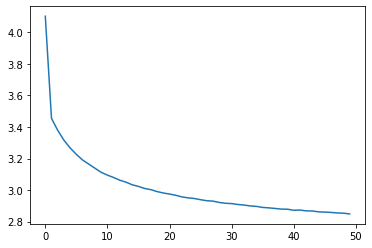

In [23]:
plt.plot(history['loss'])

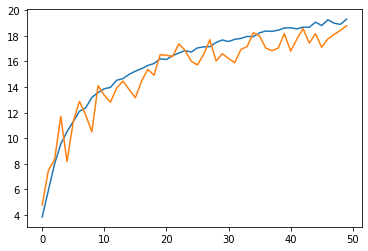

In [24]:
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])

In [25]:
evaluate_accuracy(net,transform,test_loader)

18.79145842798728

In [26]:
accuracy_classes(net,transform,test_loader,labels)

Accuracy for class: backward is 0.0 %
Accuracy for class: bed   is 1.0 %
Accuracy for class: bird  is 48.1 %
Accuracy for class: cat   is 22.7 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: down  is 22.4 %
Accuracy for class: eight is 58.6 %
Accuracy for class: five  is 18.9 %
Accuracy for class: follow is 39.5 %
Accuracy for class: forward is 0.0 %
Accuracy for class: four  is 11.2 %
Accuracy for class: go    is 4.0 %
Accuracy for class: happy is 0.0 %
Accuracy for class: house is 5.8 %
Accuracy for class: learn is 3.1 %
Accuracy for class: left  is 22.8 %
Accuracy for class: marvin is 3.1 %
Accuracy for class: nine  is 23.3 %
Accuracy for class: no    is 2.7 %
Accuracy for class: off   is 26.9 %
Accuracy for class: on    is 19.9 %
Accuracy for class: one   is 31.1 %
Accuracy for class: right is 0.8 %
Accuracy for class: seven is 7.4 %
Accuracy for class: sheila is 14.2 %
Accuracy for class: six   is 23.9 %
Accuracy for class: stop  is 25.5 %
Accuracy for class: three is 30.

## Very Deep CNN for raw waveforms

The waveform is studied using 1 dimensional CNN. Same as: https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

See also: https://arxiv.org/pdf/1610.00087.pdf

In [27]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2).squeeze()

In [38]:
T=8000

In [39]:
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=T).to(device)

In [40]:
model = M5(n_input=1, n_output=len(labels)).to(device)

In [41]:
criterion = nn.NLLLoss()

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

In [43]:
summary(model,(1,T))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 496]           2,592
       BatchNorm1d-2              [-1, 32, 496]              64
         MaxPool1d-3              [-1, 32, 124]               0
            Conv1d-4              [-1, 32, 122]           3,104
       BatchNorm1d-5              [-1, 32, 122]              64
         MaxPool1d-6               [-1, 32, 30]               0
            Conv1d-7               [-1, 64, 28]           6,208
       BatchNorm1d-8               [-1, 64, 28]             128
         MaxPool1d-9                [-1, 64, 7]               0
           Conv1d-10                [-1, 64, 5]          12,352
      BatchNorm1d-11                [-1, 64, 5]             128
        MaxPool1d-12                [-1, 64, 1]               0
           Linear-13                [-1, 1, 35]           2,275
Total params: 26,915
Trainable params: 

In [44]:
num_epochs=20

In [45]:
history=training(model,transform,optimizer,criterion,train_loader,test_loader,num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Loss: 1.8693 Acc: 45.8223% Val Acc: 64.8251%
Epoch 2 Loss: 0.9831 Acc: 71.0194% Val Acc: 68.7324%
Epoch 3 Loss: 0.8024 Acc: 76.1819% Val Acc: 76.4925%
Epoch 4 Loss: 0.7259 Acc: 78.4579% Val Acc: 75.7201%
Epoch 5 Loss: 0.6782 Acc: 79.8404% Val Acc: 77.3194%
Epoch 6 Loss: 0.6403 Acc: 80.9967% Val Acc: 76.0473%
Epoch 7 Loss: 0.6142 Acc: 81.8382% Val Acc: 79.5638%
Epoch 8 Loss: 0.5981 Acc: 82.0881% Val Acc: 79.9546%
Epoch 9 Loss: 0.5738 Acc: 82.8530% Val Acc: 78.4916%
Epoch 10 Loss: 0.5703 Acc: 82.9827% Val Acc: 81.4085%
Epoch 11 Loss: 0.5555 Acc: 83.4188% Val Acc: 80.0727%
Epoch 12 Loss: 0.5425 Acc: 83.8785% Val Acc: 78.7733%
Epoch 13 Loss: 0.5422 Acc: 83.7370% Val Acc: 76.1926%
Epoch 14 Loss: 0.5330 Acc: 84.0258% Val Acc: 79.5184%
Epoch 15 Loss: 0.5298 Acc: 84.1684% Val Acc: 78.7097%
Epoch 16 Loss: 0.5218 Acc: 84.3098% Val Acc: 81.5811%
Epoch 17 Loss: 0.5183 Acc: 84.4065% Val Acc: 81.1449%
Epoch 18 Loss: 0.5155 Acc: 84.4843% Val Acc: 79.1186%
Epoch 19 Loss: 0.5122 Acc: 84.6434% V

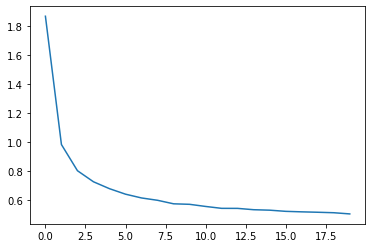

In [46]:
plt.plot(history['loss'])

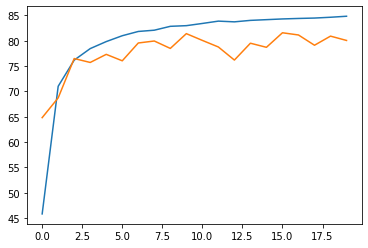

In [47]:
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])

In [49]:
evaluate_accuracy(model,transform,test_loader)

80.06360745115856

In [50]:
accuracy_classes(model,transform,test_loader,labels)

Accuracy for class: backward is 79.4 %
Accuracy for class: bed   is 77.3 %
Accuracy for class: bird  is 73.0 %
Accuracy for class: cat   is 66.5 %
Accuracy for class: dog   is 79.5 %
Accuracy for class: down  is 68.5 %
Accuracy for class: eight is 85.3 %
Accuracy for class: five  is 84.9 %
Accuracy for class: follow is 61.6 %
Accuracy for class: forward is 65.2 %
Accuracy for class: four  is 80.2 %
Accuracy for class: go    is 69.9 %
Accuracy for class: happy is 81.8 %
Accuracy for class: house is 88.0 %
Accuracy for class: learn is 49.7 %
Accuracy for class: left  is 69.7 %
Accuracy for class: marvin is 80.5 %
Accuracy for class: nine  is 83.3 %
Accuracy for class: no    is 76.8 %
Accuracy for class: off   is 84.8 %
Accuracy for class: on    is 77.8 %
Accuracy for class: one   is 88.5 %
Accuracy for class: right is 77.5 %
Accuracy for class: seven is 91.4 %
Accuracy for class: sheila is 85.4 %
Accuracy for class: six   is 90.6 %
Accuracy for class: stop  is 92.7 %
Accuracy for class: 

# To Do: Preprocessing/audio manipulation and data augmentation

https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

# To Do: try some transfer learning from pretrained model

https://pytorch.org/audio/stable/tutorials/speech_recognition_pipeline_tutorial.html#sphx-glr-tutorials-speech-recognition-pipeline-tutorial-py

Others pretrained model and tutorial: https://pytorch.org/audio/stable/pipelines.html

# To Do: try (very very) deep transformers models.

## Enformer

Paper: https://arxiv.org/abs/2010.10759

Pytorch: https://pytorch.org/audio/stable/generated/torchaudio.models.Emformer.html#torchaudio.models.Emformer

Pretrained: https://github.com/pytorch/audio/tree/main/examples/asr/emformer_rnnt

## Conformer

Paper: https://arxiv.org/abs/2005.08100

Pytorch: https://pytorch.org/audio/stable/generated/torchaudio.models.Conformer.html#torchaudio.models.Conformer



https://pytorch.org/audio/stable/pipelines.html

# Record audio from colab:

In [ ]:
def predict(tensor,model,transform):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform,model,transform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)